In [1]:
# if necessary, install NeuralGCM and dependencies
!python --version
!pip install -q -U neuralgcm dinosaur-dycore gcsfs
!pip install matplotlib
!pip install cartopy
!pip install xarray netCDF4 numpy

Python 3.11.10


## Background and Motivation

<span style="color:blue">Todo later</span> Rewrite Introduction, add any relevant thins into here
Droughts are natural disasters that are getting worse every year and therefore affecting millions of people by increasing the risk of malnutrition, diseases, wildfires, or forced migration due to droughts. Developing early warning systems and timely interventions is crucial to mitigate the economic, social, and environmental impacts of droughts.



<span style="color:blue"> Add other necessary information

## Data and Objectives

<span style="color:blue"> Todo: Add if something is missing </span> \

Data: \
ERA 5 data \
pretrained NeuralGCM model (intermediate deterministic NeuralGCM 1.4° model) \
SST data 

Objectives: \
The aim of this project is to make a 30-year roll-out prediction for drought frequency and amplitudes in the region of Spain. 

## Drought specific variables

Evapotranspiration (not in NeuralGCM) \
Precipitation (not in NeuralGCM) \
Temperature \
Specific_humidity \
Sea Surface Temperature (not in NeuralGCM)

In [22]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray as xr

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

import matplotlib.pyplot as plt
import cartopy
import pandas as pd
import signal
import sys
import jax

from PIL import Image
from IPython.display import display
from scipy.stats import norm
from numba import jit

gcs = gcsfs.GCSFileSystem(token='anon')

In [2]:
ersst_path = "./data/tos_Omon_GISS-E2-1-G_historical_r1i1p5f1_gn_200101-201412.nc"
ersst_data = xr.open_dataset(ersst_path)

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`

In [19]:
gcs = gcsfs.GCSFileSystem(token='anon')
model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'
with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
    ckpt = pickle.load(f)

/tmp/ipykernel_70987/981810831.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ckpt = pickle.load(f)


## Change checkpoint to include surface pressure as a variable as an output and enforce a constant global mean log surface pressure

In [20]:
new_inputs_to_units_mapping = {
    'u': 'meter / second',
    'v': 'meter / second',
    't': 'kelvin',
    'z': 'm**2 s**-2',
    'sim_time': 'dimensionless',
    'tracers': {'specific_humidity': 'dimensionless',
                'specific_cloud_liquid_water_content': 'dimensionless',
                'specific_cloud_ice_water_content': 'dimensionless',
    },

    'diagnostics': {
        'surface_pressure': 'kg / (meter s**2)',
        'sst_anomalies': 'kelvin', 
        'P_minus_E_cumulative': 'kg / (meter**2)'
        # Add new diagnostic variables if any
    }
}

new_model_config_str = '\n'.join([
        ckpt['model_config_str'],
        f'DimensionalLearnedPrimitiveToWeatherbenchDecoder.inputs_to_units_mapping = {new_inputs_to_units_mapping}',
        'DimensionalLearnedPrimitiveToWeatherbenchDecoder.diagnostics_module = @NodalModelDiagnosticsDecoder',
        'StochasticPhysicsParameterizationStep.diagnostics_module = @PrecipitationMinusEvaporationDiagnostics',
        'PrecipitationMinusEvaporationDiagnostics.method = "cumulative"',
        'PrecipitationMinusEvaporationDiagnostics.moisture_species =  ("specific_humidity", "specific_cloud_liquid_water_content", "specific_cloud_ice_water_content")',])

ckpt['model_config_str'] = new_model_config_str

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Subset the data and compute some variables
<span style="color:red">TODO </span> SST still NAN for Spain

<span style="color:blue">TODO later </span> Add short info about AMO and SST Anomalies?

## <span style ="color:red"> Need to change start time and end time
Chose data: Start_time = 1940-01-01, End_time = 1989-12-31

In [31]:
start_time = '1989-01-01'
end_time = '1998-01-02'
data_inner_steps = 24

lat_bounds = [slice(34, 45), slice(34, 51)] 
lon_bounds = [slice(-25, 19), slice(-20, 10)]  

In [8]:
sst_subset = ersst_data['tos'].sel(time=slice(start_time, end_time),
                                   lat=lat_bounds[0],
                                   lon=lon_bounds[0])

sst_subset['time'] = sst_subset.indexes['time']
climatology = sst_subset.mean(dim='time') 

sst_anomalies = sst_subset - climatology
sst_anomalies.to_netcdf('sst_anomalies.nc')
amo_index = sst_anomalies.mean(dim=['lat', 'lon'])

## Visualization of these computed values

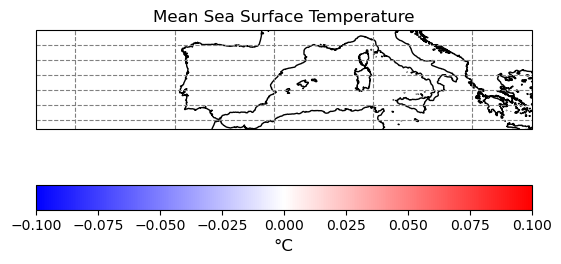

In [32]:
region = [-24, 26, 35, 45] 

plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(
    sst_subset['lon'], 
    sst_subset['lat'], 
    climatology, 
    transform=cartopy.crs.PlateCarree(), 
    shading='auto', 
    cmap='bwr'
)
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='Mean Temperature')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("Mean Sea Surface Temperature")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

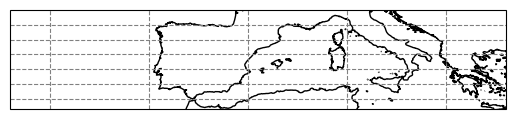

In [33]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(sst_subset['lon'], sst_subset['lat'], sst_anomalies[0,:,:], transform=cartopy.crs.PlateCarree(), shading='auto',cmap='bwr')
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='SST Anomalies')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("SST Anomalies")
plt.show()

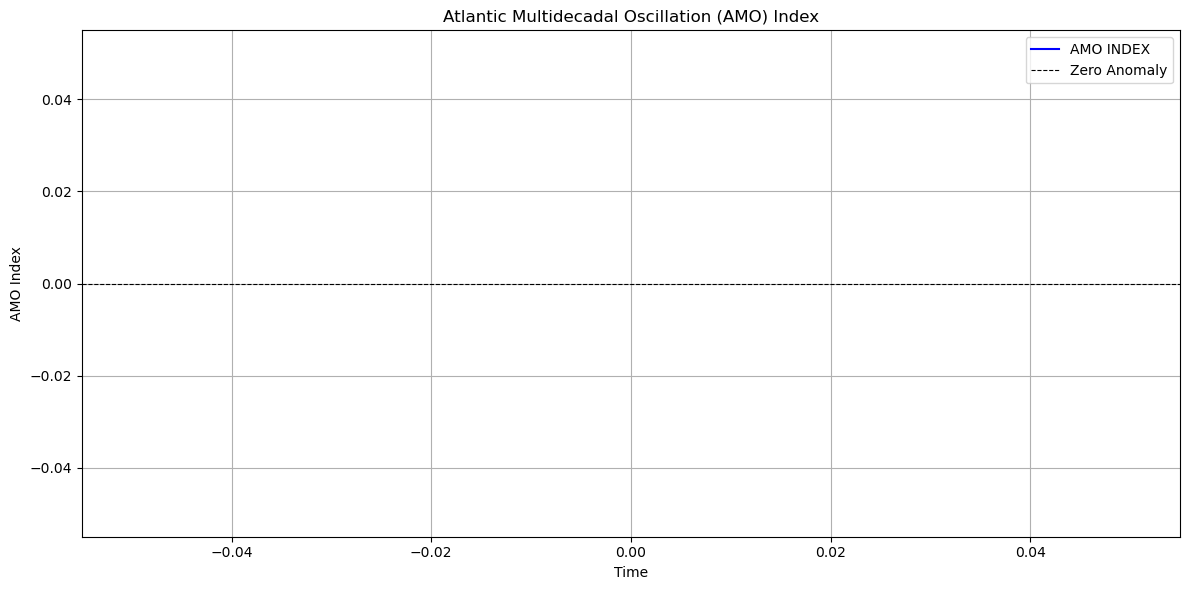

In [34]:
plt.figure(figsize=(12,6))
plt.plot(amo_index, label="AMO INDEX", color="b")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8, label="Zero Anomaly")
plt.title("Atlantic Multidecadal Oscillation (AMO) Index")
plt.xlabel("Time")
plt.ylabel("AMO Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Load ERA5 data from GCP/Zarr

In [35]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xr.open_zarr(gcs.get_mapper(era5_path), chunks=None)

<span style="color:green"></span>Incorporate the processed SST data or derived indices into your drought prediction model as predictors or covariates. \
<span style="color:blue">Todo later</span> Remove the next two boxes

In [36]:
#sst_anomalies = sst_anomalies.rename({'lat': 'latitude', 'lon': 'longitude'})
print(sst_anomalies)
print(sst_anomalies.dims)

if 'sea_surface_temperature' not in full_era5:
    raise ValueError("SST variable not found in the dataset!")

<xarray.DataArray 'tos' (time: 0, lat: 6, lon: 8)> Size: 0B
array([], shape=(0, 6, 8), dtype=float32)
Coordinates:
  * lat      (lat) float64 48B 35.0 37.0 39.0 41.0 43.0 45.0
  * lon      (lon) float64 64B 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75
  * time     (time) object 0B 
('time', 'lat', 'lon')


In [37]:
print(full_era5["mean_total_precipitation_rate"])
for i in full_era5:
    if "wind" in i:
        print(i)

<xarray.DataArray 'mean_total_precipitation_rate' (time: 1323648,
                                                   latitude: 721,
                                                   longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Mean total precipitation rate
    short_name:  mtpr
    units:       kg m**-2 s**-1
100m_u_component_of_wind
100m_v_component_of_wind
10m_u_component_of_neutral_wind
10m_u_component_of_wind
10m_v_component_of_neutral_wind
10m_v_component_of_wind
10m_wind_gust_since_previous_post_processing
instantaneous_10m_wind_gust
mean_direction_of_wind_waves
mean_period_of_wind_waves
mean_wave_period_based_on_first_moment_for_wind_waves
mean_wave_period_based_on_second_moment_for_

## <span style="color:red"> TODO</span> set different time
01-01-1960, 01-01-1990

In [39]:
# Step 1: Subset the region and time range
time_bounds = slice('1990-01-01' ,'1990-01-02')
lat_bounds = slice(51, 34)  
lon_bounds = slice(-20, 10)
subset = full_era5.sel(latitude=lat_bounds, longitude=lon_bounds, time=time_bounds)

## Regrid to NeuralGCM's native resolution: 

In [40]:
sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(start_time, end_time, data_inner_steps))
    .compute()
)

era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)

regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
    
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

MemoryError: Unable to allocate 471. GiB for an array with shape (3289, 37, 721, 1440) and data type float32

## Make the forecast

<span style="color:blue"> TODO later </span> add description?

In [44]:
class GracefulExit:
    """Handles graceful exit and file closing."""
    def __init__(self, file):
        self.file = file
        self.is_running = True

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.cleanup()

    def cleanup(self):
        print("Shutting down gracefully...")
        if not self.file.closed:
            self.file.close()
        self.is_running = False

# Signal handler to trigger cleanup
def handle_signal(signum, frame):
    global graceful_exit_context
    graceful_exit_context.cleanup()

In [ ]:
# Parameters for 30-year rollout
years = 30
days_per_year = 365  # Exclude leap years for simplicity
inner_steps = 24  # Save model outputs every 24 hours
hours_per_day = 24
outer_steps = (days_per_year * years * hours_per_day) // inner_steps  # Total steps for 30 years
timedelta = np.timedelta64(inner_steps, 'h')  # Time interval between model outputs
times = np.arange(outer_steps) * inner_steps  # Time axis in hours

# Placeholder model and data (replace with actual implementations)
# model = ...
# eval_era5 = ...

In [43]:
# Register signal handlers
signal.signal(signal.SIGINT, handle_signal)
signal.signal(signal.SIGTERM, handle_signal)

output_file = "30_year_rollout_predictions.nc"

with open(output_file, "w") as nc_file:
    with GracefulExit(nc_file) as graceful_exit_context:
        try:
            # Initialize model state
            print("Initializing model state...")
            inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
            input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
            rng_key = jax.random.key(42)  # Optional for deterministic models
            initial_state = model.encode(inputs, input_forcings, rng_key)

            # Use persistence for forcing variables (e.g., SST and sea ice cover)
            print("Using persistent forcing variables...")
            all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

            # Make forecast
            print(f"Starting 30-year rollout with {outer_steps} steps...")
            final_state, predictions = model.unroll(
                initial_state,
                all_forcings,
                steps=outer_steps,
                timedelta=timedelta,
                start_with_input=True,
            )

            # Convert predictions to xarray dataset
            print("Converting predictions to xarray.Dataset...")
            #print(predictions)
            predictions_ds = model.data_to_xarray(predictions, times=times)
            print(predictions_ds)
            # Save results to a NetCDF file
            print("Applying chunking to the dataset...")
            #chunked_ds = predictions_ds.chunk({'time': 100})  # Adjust chunk size as needed
            #chunked_ds.to_netcdf(output_file, mode='w', engine='netcdf4')


            # Final message
            print("30-year rollout completed successfully.")

        except Exception as e:
            print(f"An error occurred: {e}")
            graceful_exit_context.cleanup()
        finally:
            print("Execution stopped.")

Initializing model state...
An error occurred: name 'eval_era5' is not defined
Shutting down gracefully...
Execution stopped.
Shutting down gracefully...


## Compare forecast to ERA5

<span style="color:blue"> TODO later </span> add description?

In [24]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

NameError: name 'eval_era5' is not defined

In [25]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

NameError: name 'combined_ds' is not defined

## Data Analysis

In [26]:
@jit
def thornthwaite(temp, lat):
    """Calculate Potential Evapotranspiration (PET) using Thornthwaite's equation."""
    N = len(temp)
    I = sum((temp[temp > 0] / 5) ** 1.514)  # Monthly temperature index
    a = (6.75e-7 * I ** 3) - (7.71e-5 * I ** 2) + (1.792e-2 * I) + 0.49239
    PET = np.zeros(N)
    for i in range(N):
        if temp[i] > 0:
            L = 12  # Assume 12 hours of daylight on average
            PET[i] = (16 * ((10 * temp[i] / I) ** a) * (L / 12))
    return PET

In [27]:
print("Calculating PET...")
predictions_ds['PET'] = xr.apply_ufunc(
    thornthwaite,
    predictions_ds['temperature'],
    kwargs={'lat': 45},  # Replace 45 with the actual latitude if available
    vectorize=True
)

Calculating PET...


NameError: name 'predictions_ds' is not defined

In [28]:
print("Calculating D (P - PET)...")
predictions_ds['D'] = predictions_ds['P_minus_E_cumulative'] - predictions_ds['PET']

Calculating D (P - PET)...


NameError: name 'predictions_ds' is not defined

In [29]:
def compute_spei(D, scale=3):
    """Compute SPEI at a given scale (e.g., 3-month rolling)."""
    rolling_mean = D.rolling(time=scale, center=False).mean()
    rolling_std = D.rolling(time=scale, center=False).std()
    spei = (rolling_mean - rolling_mean.mean(dim="time")) / rolling_std
    return spei

print("Calculating SPEI...")
predictions_ds['SPEI'] = compute_spei(predictions_ds['D'])

Calculating SPEI...


NameError: name 'predictions_ds' is not defined

In [30]:
#Plot SPEI
def plot_spei(spei, lat=0, lon=0):
    """Plot SPEI time series for a given location."""
    spei_point = spei.sel(latitude=lat, longitude=lon, method="nearest")
    plt.figure(figsize=(10, 6))
    spei_point.plot(label="SPEI")
    plt.axhline(0, color="k", linestyle="--", linewidth=1)
    plt.title(f"SPEI at Location (lat: {lat}, lon: {lon})")
    plt.xlabel("Time")
    plt.ylabel("SPEI")
    plt.legend()
    plt.grid()
    plt.show()

# Example plot for a specific location (adjust latitude/longitude)
print("Plotting SPEI for (lat=0, lon=0)...")
plot_spei(predictions_ds['SPEI'], lat=45, lon=20)


Plotting SPEI for (lat=0, lon=0)...


NameError: name 'predictions_ds' is not defined

## Adding later

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_2.png')
display(img)

In [ ]:
img = Image.open('images/Spain_range_3.png')
display(img)